# Volatility Surface

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import spicy as sp
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.optimize import fsolve
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_rows', None)

We download the options data and the last value of underlying "symbol".

In [2]:
# Stock symbol of the underlying asset
symbol = "AAPL"

# Last value of the underlying asset
current_price = yf.Ticker(symbol).history(period='1d')['Close'].iloc[-1]

# Download of the available expiration dates
expiration_dates = yf.Ticker(symbol).options

options_data_list = []

for expiration_date in expiration_dates:
    options_full_data = yf.Ticker(symbol).option_chain(expiration_date)
    
    # call data
    calls = options_full_data.calls
    calls_mid_prices = calls[['strike']].assign(Mid_Price_Call=(calls['bid'] + calls['ask']) / 2)
    
    # put data
    puts = options_full_data.puts
    puts_mid_prices = puts[['strike']].assign(Mid_Price_Put=(puts['bid'] + puts['ask']) / 2)
    
    merged_data = pd.merge(calls_mid_prices, puts_mid_prices, on='strike', how='outer')
    
    # Remaining Days
    expiration_date = pd.to_datetime(expiration_date)
    remaining_days = float((expiration_date - datetime.today()).days)
    merged_data['Remaining Days'] = remaining_days
    options_data_list.append(merged_data)

options_df = pd.concat(options_data_list, ignore_index=True)

# Some conditions
options_df = options_df[options_df['Remaining Days'] <= 100]
options_df = options_df[(options_df['strike'] >= 0.8 * current_price) & (options_df['strike'] <= 1.2 * current_price)]

print(options_df)
print('current_price = ',current_price)

     strike  Mid_Price_Call  Mid_Price_Put  Remaining Days
26    140.0          32.950          0.005             2.0
27    145.0          28.000          0.010             2.0
28    147.0          25.900          0.015             2.0
29    150.0          22.975          0.015             2.0
30    152.5          20.375          0.020             2.0
31    155.0          17.925          0.025             2.0
32    157.5          15.400          0.035             2.0
33    160.0          12.950          0.045             2.0
34    162.5          10.500          0.065             2.0
35    165.0           8.000          0.105             2.0
36    167.5           5.625          0.215             2.0
37    170.0           3.550          0.535             2.0
38    172.5           1.745          1.330             2.0
39    175.0           0.745          2.775             2.0
40    177.5           0.255          4.875             2.0
41    180.0           0.095          7.250             2

We calculate the implied volatilities of calls and puts using the Newton-Raphson method.

In [3]:
def blackscholes(sigma, S, K, option_price, T, r, option_type='CALL'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'CALL':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) - option_price
    elif option_type == 'PUT':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1) - option_price
    return price

S = current_price
r = 0.05 #arbitrary value
sigma0 = 0.6 #arbitrary value
implvol_calls = []
implvol_puts = []

for index, row in options_df.iterrows():
  K = row['strike']
  T = row['Remaining Days'] / 365
  
  # implied volatility for calls
  imp_vol_call = fsolve(blackscholes, sigma0, args=(S, K, row['Mid_Price_Call'], T, r, 'CALL'), xtol=1e-8, maxfev=500)
  implvol_calls.append(imp_vol_call[0])
  
  # implied volatility for puts
  imp_vol_put = fsolve(blackscholes, sigma0, args=(S, K, row['Mid_Price_Put'], T, r, 'PUT'), xtol=1e-8, maxfev=500)
  implvol_puts.append(imp_vol_put[0])

# Change into dataframe
implvol_df_calls = pd.DataFrame(implvol_calls, columns=['ImplVol Call'])
implvol_df_puts = pd.DataFrame(implvol_puts, columns=['ImplVol Put'])


selected_columns = ['strike', 'Remaining Days']
vol_surface_df = options_df[selected_columns].copy()
vol_surface_df['ImplVol Call'] = implvol_calls
vol_surface_df['ImplVol Put'] = implvol_puts

print(vol_surface_df)

C:\Users\hippo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


     strike  Remaining Days  ImplVol Call  ImplVol Put
26    140.0             2.0      0.387982     0.973978
27    145.0             2.0      0.344734     0.881726
28    147.0             2.0      0.265135     0.855428
29    150.0             2.0      0.259910     0.760244
30    152.5             2.0      0.225925     0.704582
31    155.0             2.0      0.105813     0.641685
32    157.5             2.0      0.143715     0.585584
33    160.0             2.0      0.130600     0.519592
34    162.5             2.0      0.009719     0.458734
35    165.0             2.0      0.012502     0.401195
36    167.5             2.0      0.051744     0.357325
37    170.0             2.0      0.263509     0.332788
38    172.5             2.0      0.261034     0.329476
39    175.0             2.0      0.282631     0.344161
40    177.5             2.0      0.293696     0.407555
41    180.0             2.0      0.320328     0.498972
42    182.5             2.0      0.358836     0.605378
43    185.

Finally, we plot the volatility surface.

<IPython.core.display.Javascript object>


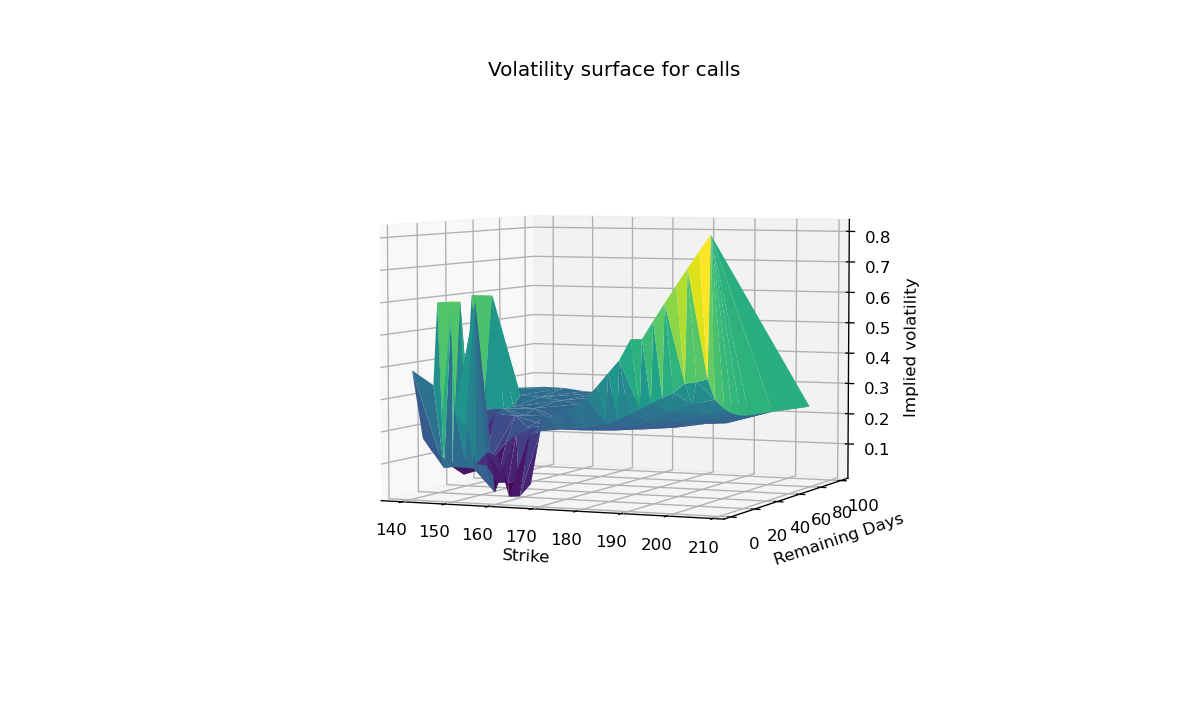

<IPython.core.display.Javascript object>


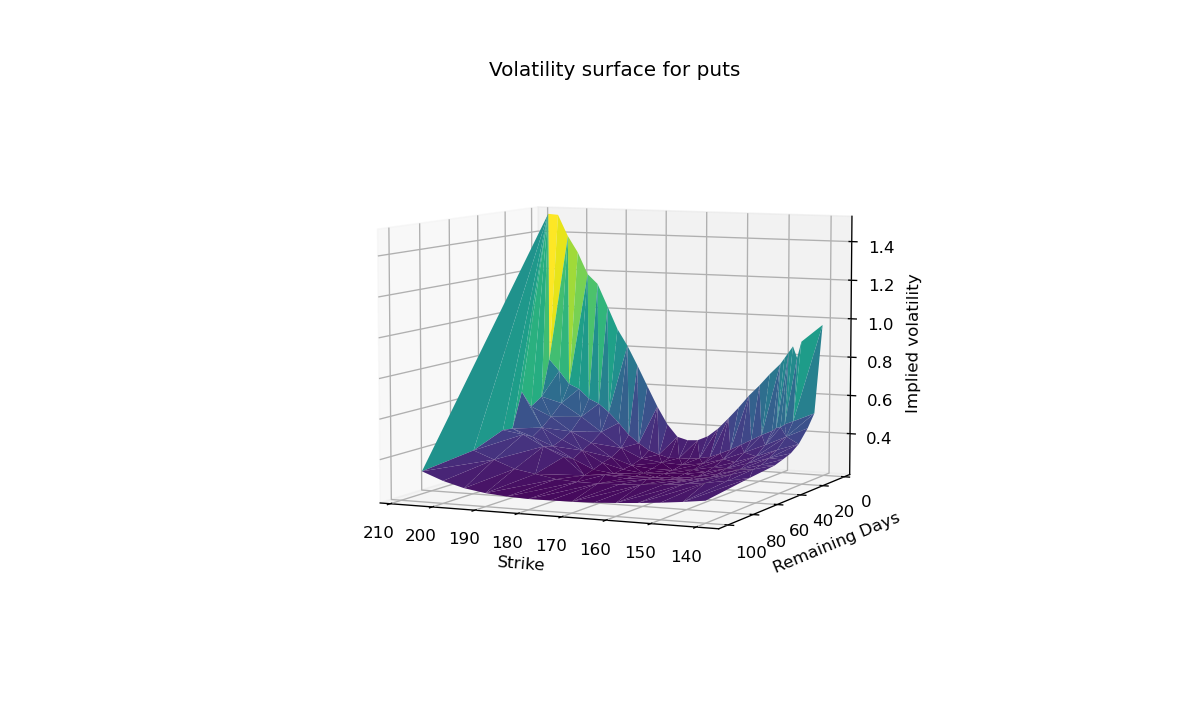

In [5]:
%matplotlib notebook

# Volatility surface for calls
fig_call = plt.figure(figsize=(10, 6))
ax_call = fig_call.add_subplot(111, projection='3d')

ax_call.plot_trisurf(vol_surface_df['strike'], vol_surface_df['Remaining Days'], vol_surface_df['ImplVol Call'], cmap='viridis')
ax_call.set_xlabel('Strike')
ax_call.set_ylabel('Remaining Days')
ax_call.set_zlabel('Implied volatility')
ax_call.set_title('Volatility surface for calls')
plt.show()

# # Volatility surface for puts
fig_put = plt.figure(figsize=(10, 6))
ax_put = fig_put.add_subplot(111, projection='3d')

ax_put.plot_trisurf(vol_surface_df['strike'], vol_surface_df['Remaining Days'], vol_surface_df['ImplVol Put'], cmap='viridis')
ax_put.set_xlabel('Strike')
ax_put.set_ylabel('Remaining Days')
ax_put.set_zlabel('Implied volatility')
ax_put.set_title('Volatility surface for puts')
plt.show()